In [1]:

from nibabel.testing import data_path
import brainspace
import pandas as pd
import numpy as np
import os
import nibabel as nib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
grads = ["1", "2", "3"]
sessions_4k = []
directory = "HCP/resampled_grads/"
subjects = ["100206", "100307", "100408", "100610", "101006"]

for session_n in ["1", "2"]:
    subjects_grads_4k = []
    for subject_id in subjects:
        gradients = []
        for grad in grads:
            path_L = directory + "%s_grad%s_ses%s_L4k.func.gii" % (subject_id, grad, session_n)
            path_R = directory + "%s_grad%s_ses%s_R4k.func.gii" % (subject_id, grad, session_n)
            gradient_L = nib.load(path_L).agg_data()
            gradient_R = nib.load(path_R).agg_data()
            grad = np.concatenate((gradient_L, gradient_R))
            gradients.append(grad)
            #print("gradient: ", grad)
        gradients = np.stack((gradients))
        #print("gradients: ", gradients)
        subjects_grads_4k.append(gradients)
    subjects_grads_4k = np.stack((subjects_grads_4k))
    #print("subjects_grads_4k: ", subjects_grads_4k)
    sessions_4k.append(subjects_grads_4k)
sessions_4k = np.stack((sessions_4k))

In [3]:
sessions_4k = sessions_4k.reshape(10, 3, 8004)
gradients4k_all_sessions = [subject_grads[:, ~(subject_grads == 0).all(axis=0)] for subject_grads in sessions_4k]


In [6]:
from brainspace.gradient.alignment import ProcrustesAlignment

alignment = ProcrustesAlignment()
gradients4k_all_sessions_aligned = alignment.fit(gradients4k_all_sessions[1:], gradients4k_all_sessions[0]) #aligningm first subject, 1st sessions as reference

In [ ]:
np.save(file = "aligned_gradients.npy", arr = np.asarray(gradients4k_all_sessions_aligned.aligned_))

In [4]:
all_gradients4k_all_sessions_aligned = np.load("aligned_gradients.npy")
all_gradients4k_all_sessions_aligned = np.insert(arr = all_gradients4k_all_sessions_aligned, obj = 0, values = np.expand_dims(gradients4k_all_sessions[0], axis = 0), axis = 0)

In [5]:
labs_L_4k_metric = nib.load('HCP/labels/fsLR.4k.L.label_metric.gii').agg_data() # loading labels resampled with 2 diff. techniques
labs_R_4k_metric = nib.load('HCP/labels/fsLR.4k.R.label_metric.gii').agg_data()
labs_4k_metric  = np.concatenate((labs_L_4k_metric, labs_R_4k_metric))

labs_L_4k = nib.load('HCP/labels/fsLR.4k.L.label.gii').agg_data()
labs_R_4k = nib.load('HCP/labels/fsLR.4k.R.label.gii').agg_data()
labs_4k  = np.concatenate((labs_L_4k, labs_R_4k)) # the right labels

In [6]:
labs_4k_metric = labs_4k_metric.astype(float)
labs_4k_metric[labs_4k_metric == 0] = np.nan
cortical_indices_4k_metric = np.where(np.isnan(labs_4k_metric) == False)[0]

labs_4k = labs_4k.astype(float)
labs_4k[labs_4k == 0] = np.nan
medial_wall_mask = np.where(np.isnan(labs_4k) == True)[0] # medial wall mask from the right labels

In [7]:
grads_ses1_4k_aligned = all_gradients4k_all_sessions_aligned[:int(len(all_gradients4k_all_sessions_aligned)/2)] # shape (subj, grad, vertices)
grads_ses2_4k_aligned = all_gradients4k_all_sessions_aligned[int(len(all_gradients4k_all_sessions_aligned)/2):]

labeled_grads_ses1_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses1_4k_aligned[:] = np.nan

labeled_grads_ses2_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses2_4k_aligned[:] = np.nan

for subject, subject_map in zip(grads_ses1_4k_aligned, labeled_grads_ses1_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_mask] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_mask] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_mask] = np.nan

for subject, subject_map in zip(grads_ses2_4k_aligned, labeled_grads_ses2_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_mask] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_mask] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_mask] = np.nan

Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_89912/343670727.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_89912/343670727.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses2.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_89912/343670727.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_89912/343670727.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses2.show()


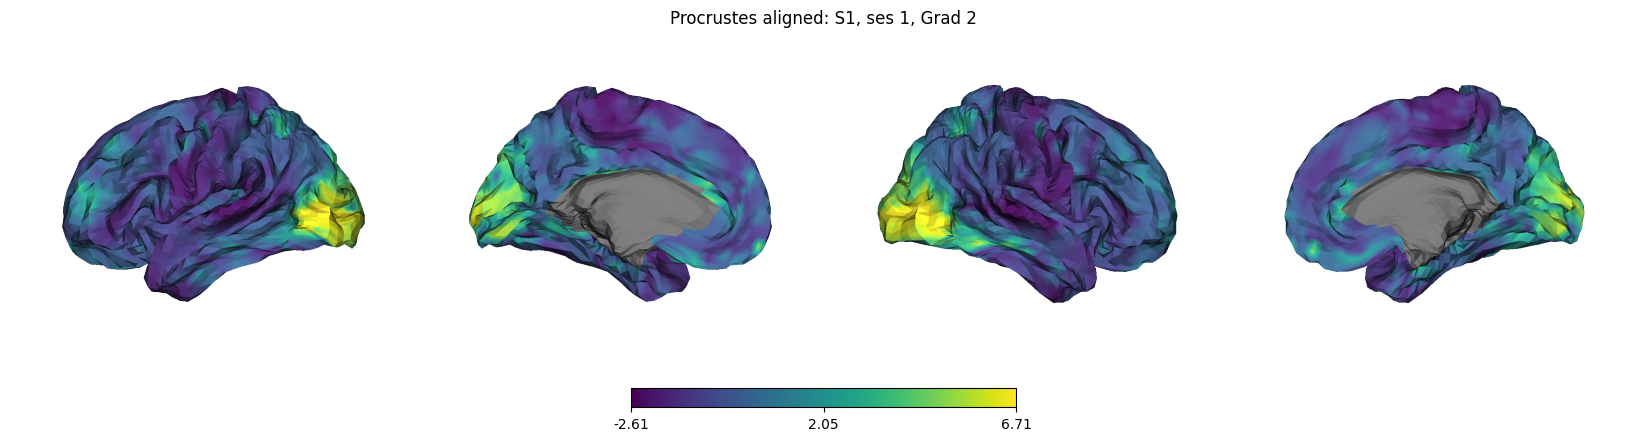

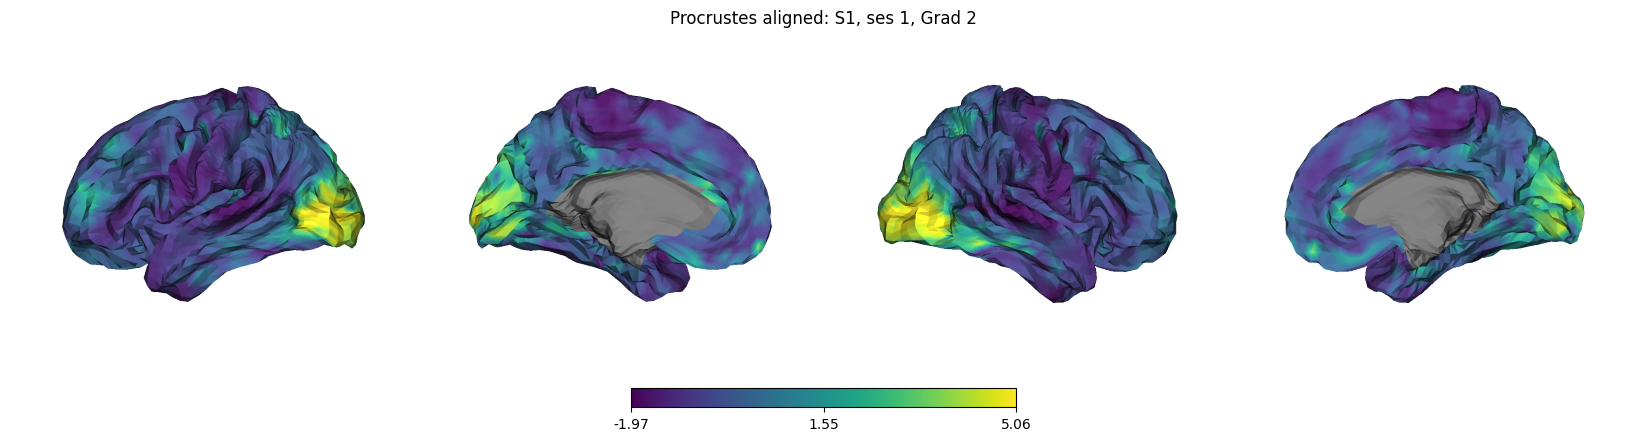

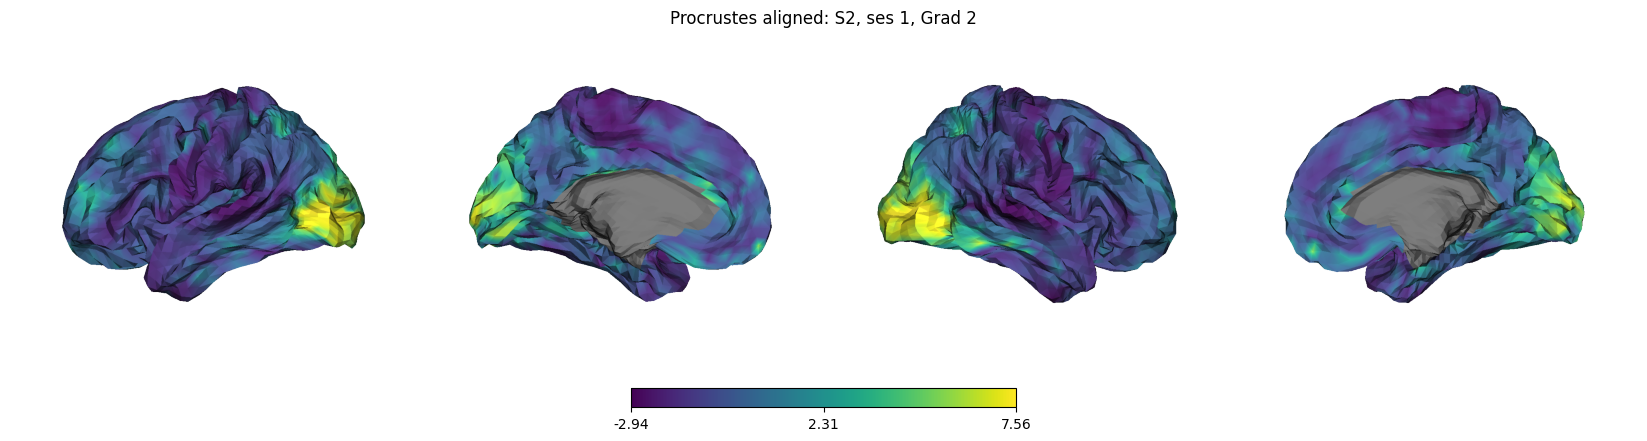

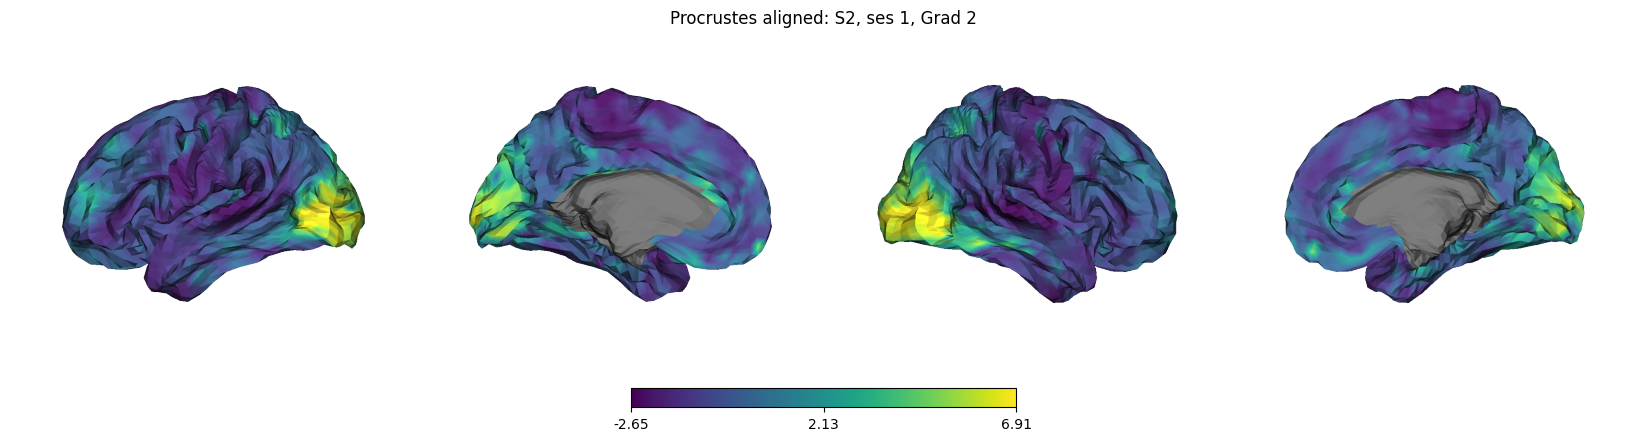

In [8]:
#plot the second gradient from 2 subjects, both sessions
from surfplot.plotting import Plot

grad2_s1_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False) 
grad2_s1_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)

grad2_s1_ses1.add_layer(labeled_grads_ses1_4k_aligned[0][1], cmap='viridis')
grad2_s1_ses2.add_layer(labeled_grads_ses2_4k_aligned[0][1], cmap='viridis')

grad2_s2_ses1.add_layer(labeled_grads_ses1_4k_aligned[1][1], cmap='viridis')
grad2_s2_ses2.add_layer(labeled_grads_ses2_4k_aligned[1][1], cmap='viridis')


grad2_s1_ses1 = grad2_s1_ses1.build()
grad2_s1_ses1.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s1_ses2 = grad2_s1_ses2.build()
grad2_s1_ses2.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s2_ses1 = grad2_s2_ses1.build()
grad2_s2_ses1.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s2_ses2 = grad2_s2_ses2.build()
grad2_s2_ses2.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s1_ses1.show()
grad2_s1_ses2.show()
grad2_s2_ses1.show()
grad2_s2_ses2.show()